In [1]:
import re
import csv
import time
import requests
import datetime
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
import os
import glob

csvs = glob.glob('./match_data_yearly/*.csv')
df_match = pd.DataFrame()
for csv in csvs:
    df_match = df_match.append(pd.read_csv(csv))

# df_match = pd.read_csv("./match_data_yearly/2006.csv")
df_match = df_match.sort_values(['Date','Sec']).reset_index(drop=True)
df_match

,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances
0,2006,1,2006-03-04 00:00:00,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916
1,2006,1,2006-03-05 00:00:00,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277
2,2006,1,2006-03-05 00:00:00,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531
3,2006,1,2006-03-05 00:00:00,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564
4,2006,1,2006-03-05 00:00:00,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199
...,...,...,...,...,...,...,...,...,...,...,...,...
4585,2020,34,2020-12-19 00:00:00,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251
4586,2020,34,2020-12-19 00:00:00,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825
4587,2020,34,2020-12-19 00:00:00,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966
4588,2020,34,2020-12-19 00:00:00,fc-tokyo,vissel-kobe,22,18,1,0,1,味スタ,14373


In [3]:
df_club = pd.read_csv("./club_and_id.csv")
df_club

,club_id,club,club_ja
0,1,kashima-antlers,鹿島
1,2,jef-united,千葉
2,3,urawa-red-diamonds,浦和
3,4,tokyo-verdy,東京Ｖ
4,5,yokohama-fa-marinos,横浜FM
5,6,yokohama-flugels,横浜Ｆ
6,7,shimizu-s-pulse,清水
7,8,nagoya-grampus-eight,名古屋
8,9,gamba-osaka,Ｇ大阪
9,10,sanfrecce-hiroshima,広島


In [4]:
club_ids = list(df_club["club_id"])[:-1:]
clubs = list(df_club["club"])[:-1:]
initial_rates = [1600,1560,1600,1360,1520,1360,1440,1440,1600,1520,1360,1360,1560,1360,1360,1560,1520,1480,1400,1400,1440,1400,1360,1480,1360,1360,1360,1360,1360,1360,1480]

In [5]:
date_index = pd.date_range(start="2006-03-04", end="2020-12-20", freq="D")

In [6]:
df_elo=pd.DataFrame(columns=clubs,index = date_index )
df_elo

,kashima-antlers,jef-united,urawa-red-diamonds,tokyo-verdy,yokohama-fa-marinos,yokohama-flugels,shimizu-s-pulse,nagoya-grampus-eight,gamba-osaka,sanfrecce-hiroshima,...,ventforet-kofu,montedio-yamagata,oita-trinita,sagan-tosu,yokohama-fc,tokushima-vortis,matsumoto-yamaga,v-varen-nagasaki,vegalta-sendai,albirex-niigata
2006-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_elo.loc["2006-03-04"] = [1600,1560,1600,1360,1520,1360,1440,1440,1600,1520,1360,1360,1560,1360,1360,1560,1520,1480,1400,1400,1440,1400,1360,1480,1360,1360,1360,1360,1360,1360,1480]
df_elo

,kashima-antlers,jef-united,urawa-red-diamonds,tokyo-verdy,yokohama-fa-marinos,yokohama-flugels,shimizu-s-pulse,nagoya-grampus-eight,gamba-osaka,sanfrecce-hiroshima,...,ventforet-kofu,montedio-yamagata,oita-trinita,sagan-tosu,yokohama-fc,tokushima-vortis,matsumoto-yamaga,v-varen-nagasaki,vegalta-sendai,albirex-niigata
2006-03-04,1600,1560,1600,1360,1520,1360,1440,1440,1600,1520,...,1400,1360,1480,1360,1360,1360,1360,1360,1360,1480
2006-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_match["Date"] =  pd.to_datetime(df_match["Date"])
df_match

,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances
0,2006,1,2006-03-04,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916
1,2006,1,2006-03-05,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277
2,2006,1,2006-03-05,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531
3,2006,1,2006-03-05,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564
4,2006,1,2006-03-05,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199
...,...,...,...,...,...,...,...,...,...,...,...,...
4585,2020,34,2020-12-19,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251
4586,2020,34,2020-12-19,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825
4587,2020,34,2020-12-19,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966
4588,2020,34,2020-12-19,fc-tokyo,vissel-kobe,22,18,1,0,1,味スタ,14373


In [9]:
def calculate_rate(home_rate,away_rate,g):
    k=16
    e = 1 /(1+pow(10, (away_rate-home_rate)/400) )
    home_rate =  home_rate+k*(g-e)
    away_rate = away_rate+k*(abs(g-1)-(1-e))
    return home_rate,away_rate

In [10]:
g=0
def calculate_g(n):
    if n == 1:
        g=1
    elif n == 0:
        g=0.5
    else:
        g=0
        
    return g
    

In [11]:
# for index,row in df_elo.iterrows():
#     for i,r in df_match.iterrows():
#         if index == r["Date"] :
            
#             home_rate= df_elo.loc[index, r["Home"]]
#             away_rate= df_elo.loc[index, r["Away"]]
            
# #             print(home_rate, away_rate, calculate_g(r["W/L"]))

#             home_rate_upd = calculate_rate(home_rate, away_rate, calculate_g(r["W/L"]))[0]
#             away_rate_upd = calculate_rate(home_rate, away_rate, calculate_g(r["W/L"]))[1]
            
#             df_elo.at[index+pd.tseries.offsets.Day(),r["Home"]] = home_rate_upd
#             df_elo.at[index+pd.tseries.offsets.Day(), r["Away"]] = away_rate_upd
            
#         else:
            
            
#             print(home_rate_upd,away_rate_upd)
#             row[r["Home"]] = calculate_rate(home_rate, away_rate, calculate_g(r["W/L"]))[0]
#             row[r["Away"]] = calculate_rate(home_rate, away_rate, calculate_g(r["W/L"]))[1]    
            
            
# for index, row in df_match.iterrows():
#     for i,r in df_elo.iterrows():
        
#         if i == row["Date"]:            
#             home_rate= df_elo.loc[i, row["Home"]]
#             away_rate= df_elo.loc[i, row["Away"]]
            
#             print(home_rate,away_rate)
            
#             home_rate_upd = calculate_rate(home_rate, away_rate, calculate_g(row["W/L"]))[0]
#             away_rate_upd = calculate_rate(home_rate, away_rate, calculate_g(row["W/L"]))[1] 
            
# #             row[r["Home"]] = calculate_rate(home_rate, away_rate, calculate_g(r["W/L"]))[0]
# #             row[r["Away"]] = calculate_rate(home_rate, away_rate, calculate_g(r["W/L"]))[1]    
#             df_elo.at[i + pd.tseries.offsets.Day(),row["Home"]] = home_rate_upd
#             df_elo.at[i + pd.tseries.offsets.Day(),row["Away"]] = away_rate_upd

# for d in 

In [12]:
df_elo.index[0]+pd.tseries.offsets.Day()

Timestamp('2006-03-05 00:00:00', freq='D')

In [13]:
df_elo

,kashima-antlers,jef-united,urawa-red-diamonds,tokyo-verdy,yokohama-fa-marinos,yokohama-flugels,shimizu-s-pulse,nagoya-grampus-eight,gamba-osaka,sanfrecce-hiroshima,...,ventforet-kofu,montedio-yamagata,oita-trinita,sagan-tosu,yokohama-fc,tokushima-vortis,matsumoto-yamaga,v-varen-nagasaki,vegalta-sendai,albirex-niigata
2006-03-04,1600,1560,1600,1360,1520,1360,1440,1440,1600,1520,...,1400,1360,1480,1360,1360,1360,1360,1360,1360,1480
2006-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_match

,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances
0,2006,1,2006-03-04,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916
1,2006,1,2006-03-05,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277
2,2006,1,2006-03-05,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531
3,2006,1,2006-03-05,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564
4,2006,1,2006-03-05,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199
...,...,...,...,...,...,...,...,...,...,...,...,...
4585,2020,34,2020-12-19,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251
4586,2020,34,2020-12-19,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825
4587,2020,34,2020-12-19,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966
4588,2020,34,2020-12-19,fc-tokyo,vissel-kobe,22,18,1,0,1,味スタ,14373


In [15]:
for date in date_index:
    next_date = date+pd.tseries.offsets.Day()
    prev_date = date-pd.tseries.offsets.Day()
    
    for index, row in df_match.iterrows():
        if row["Date"] == date:
            
            home_rate= df_elo.loc[date ,row["Home"]]
            away_rate= df_elo.loc[date ,row["Away"]]
            g = calculate_g(row["W/L"])
            
            home_rate_upd,away_rate_upd = calculate_rate(home_rate, away_rate, g)
            
            df_elo.at[next_date, row["Home"]] = home_rate_upd
            df_elo.at[next_date, row["Away"]] = away_rate_upd
            
    
    df_elo[:-1:].loc[next_date]=df_elo[:-1:].loc[next_date].fillna(df_elo.loc[date])
   
    

/home/yokoyama/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-15-9e0c109f395c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elo[:-1:].loc[next_date]=df_elo[:-1:].loc[next_date].fillna(df_elo.loc[date])


KeyError: Timestamp('2020-12-20 00:00:00', freq='D')

In [16]:
df_elo

,kashima-antlers,jef-united,urawa-red-diamonds,tokyo-verdy,yokohama-fa-marinos,yokohama-flugels,shimizu-s-pulse,nagoya-grampus-eight,gamba-osaka,sanfrecce-hiroshima,...,ventforet-kofu,montedio-yamagata,oita-trinita,sagan-tosu,yokohama-fc,tokushima-vortis,matsumoto-yamaga,v-varen-nagasaki,vegalta-sendai,albirex-niigata
2006-03-04,1600,1560,1600,1360,1520,1360,1440,1440,1600,1520,...,1400,1360,1480,1360,1360,1360,1360,1360,1360,1480
2006-03-05,1600,1560,1600,1360,1520,1360,1440,1440,1600,1520,...,1400,1360,1480,1360,1360,1360,1360,1360,1360,1480
2006-03-06,1606.19,1549.34,1600,1360,1525.34,1360,1447.08,1450.66,1600,1513.81,...,1392.92,1360,1472,1360,1360,1360,1360,1360,1360,1472.92
2006-03-07,1606.19,1549.34,1600,1360,1525.34,1360,1447.08,1450.66,1600,1513.81,...,1392.92,1360,1472,1360,1360,1360,1360,1360,1360,1472.92
2006-03-08,1606.19,1549.34,1600,1360,1525.34,1360,1447.08,1450.66,1600,1513.81,...,1392.92,1360,1472,1360,1360,1360,1360,1360,1360,1472.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,1586.94,1406.88,1481.96,1386.4,1536.18,1360,1400.09,1507.37,1570.46,1525.64,...,1409.83,1349.4,1444.29,1435.1,1337.29,1308.03,1377.76,1364.42,1402.24,1400.31
2020-12-17,1586.94,1406.88,1477.91,1386.4,1536.18,1360,1392.14,1507.37,1573.78,1517.12,...,1409.83,1349.4,1451.15,1445.93,1333.97,1308.03,1377.76,1364.42,1410.19,1400.31
2020-12-18,1586.94,1406.88,1477.91,1386.4,1536.18,1360,1392.14,1507.37,1573.78,1517.12,...,1409.83,1349.4,1451.15,1445.93,1333.97,1308.03,1377.76,1364.42,1410.19,1400.31
2020-12-19,1586.94,1406.88,1477.91,1386.4,1536.18,1360,1392.14,1507.37,1573.78,1517.12,...,1409.83,1349.4,1451.15,1445.93,1333.97,1308.03,1377.76,1364.42,1410.19,1400.31


In [18]:
df_elo["shimizu-s-pulse"]

2006-03-04       1440
2006-03-05       1440
2006-03-06    1447.08
2006-03-07    1447.08
2006-03-08    1447.08
               ...   
2020-12-16    1400.09
2020-12-17    1392.14
2020-12-18    1392.14
2020-12-19    1392.14
2020-12-20    1403.98
Freq: D, Name: shimizu-s-pulse, Length: 5406, dtype: object

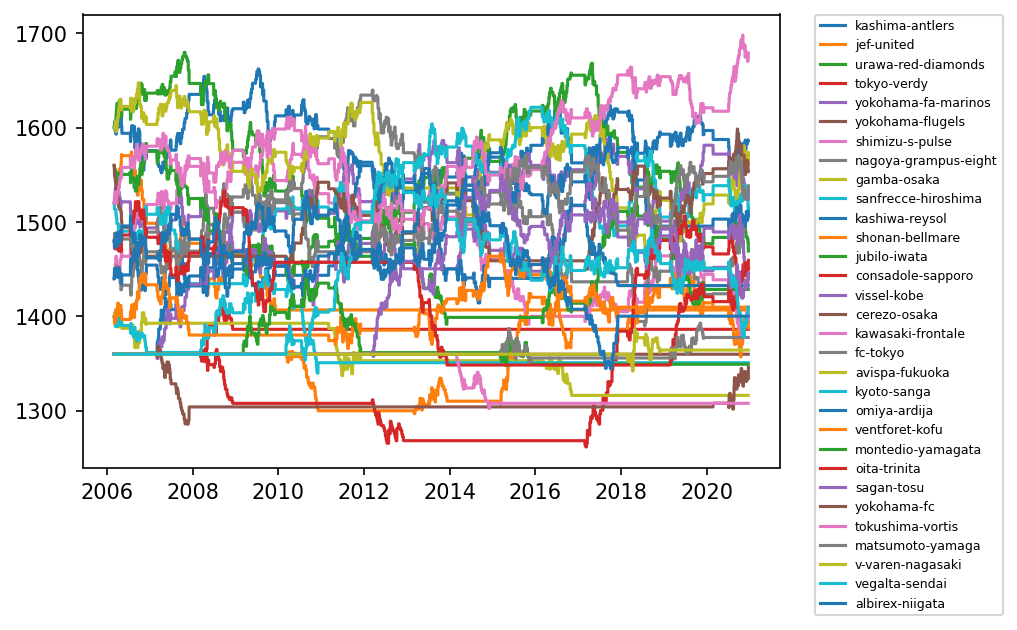

In [54]:
import matplotlib.pyplot as plt
fig = plt.figure(dpi=150)
for club in df_elo.columns:
    plt.plot(df_elo.index, df_elo[club],label=df_elo[club].name )
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=6)


In [26]:
df_elo.columns

Index(['kashima-antlers', 'jef-united', 'urawa-red-diamonds', 'tokyo-verdy',
       'yokohama-fa-marinos', 'yokohama-flugels', 'shimizu-s-pulse',
       'nagoya-grampus-eight', 'gamba-osaka', 'sanfrecce-hiroshima',
       'kashiwa-reysol', 'shonan-bellmare', 'jubilo-iwata',
       'consadole-sapporo', 'vissel-kobe', 'cerezo-osaka', 'kawasaki-frontale',
       'fc-tokyo', 'avispa-fukuoka', 'kyoto-sanga', 'omiya-ardija',
       'ventforet-kofu', 'montedio-yamagata', 'oita-trinita', 'sagan-tosu',
       'yokohama-fc', 'tokushima-vortis', 'matsumoto-yamaga',
       'v-varen-nagasaki', 'vegalta-sendai', 'albirex-niigata'],
      dtype='object')

In [34]:
df_elo[club].name

'kashima-antlers'

In [72]:
_= df_elo.loc["2020-12-19"]


In [73]:
_.sort_values(ascending=False) 

kawasaki-frontale       1674.26
kashima-antlers         1586.94
gamba-osaka             1573.78
cerezo-osaka               1553
yokohama-fa-marinos     1536.18
fc-tokyo                1532.31
sanfrecce-hiroshima     1517.12
kashiwa-reysol          1511.52
nagoya-grampus-eight    1507.37
urawa-red-diamonds      1477.91
oita-trinita            1451.15
consadole-sapporo       1450.88
sagan-tosu              1445.93
vissel-kobe             1445.81
omiya-ardija            1432.69
jubilo-iwata            1428.59
vegalta-sendai          1410.19
ventforet-kofu          1409.83
jef-united              1406.88
albirex-niigata         1400.31
shimizu-s-pulse         1392.14
shonan-bellmare         1387.73
tokyo-verdy              1386.4
matsumoto-yamaga        1377.76
v-varen-nagasaki        1364.42
yokohama-flugels           1360
kyoto-sanga             1351.03
montedio-yamagata        1349.4
yokohama-fc             1333.97
avispa-fukuoka          1316.44
tokushima-vortis        1308.03
Name: 20

In [ ]:
sorted(d, key=lambda x: x['Age'], reverse=True)